In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [15]:
ctwdf = 'CTWD_ProcessData.xlsx'
cvf = 'CV_ProcessData.xlsx'

ctwd = pd.read_excel(ctwdf, usecols=lambda x: 'Unnamed' not in x)
cv = pd.read_excel(cvf, usecols=lambda x: 'Unnamed' not in x)

# Introduction
## Variables

### Common
 - **dateTime**: time for data collection
 - **dataItemId**: Data collection target info
 - **BeadNumber**: Effectively layer
 - **value**: item specified by dataItemId
 - **beadtime (s)**: Length of time since starting that layer (note dwell)
 - **buildTime (s)**: counter since start of data collection
 - **Traverse Speed (mm/s**): Constant in this build - speed of travel 
 - **beadPosition (mm)**: derived measure based on buildTime*Traverse speed. 
 - **MovAvgValue**: Calculated 4 average of value

### CTWD only 
 - Reference value: Only used for CTWD - measure by which Value is offset by
 - ProcessValue_ref: I don't remember what this is

## Preprocessing
- Value outliers were set to NA based on 95% confidence interval
 - This filters for values that are weird at the start of a bead.
- Drop rows where value is NA

In [16]:
cv.dropna(subset=['value'], ignore_index=True, inplace=True)
ctwd.dropna(subset=['value'], ignore_index=True, inplace=True)

# Statistical Extraction

In [193]:
def extraction(grouped):
    goop = grouped.first().reset_index()
    calc = ['value', 'MovAvgValue']
    mean = grouped[calc].mean()
    skew = grouped[calc].skew()
    std = grouped[calc].std()
    mean.columns = ['mean_' + str(col) for col in mean.columns]
    skew.columns = ['skew_' + str(col) for col in skew.columns]
    std.columns = ['std_' + str(col) for col in std.columns]
    joined = mean.join([skew, std])
    return joined

In [199]:
aC_packet = packetize(aC, 10)
acpg = aC_packet.groupby(['Packet', 'Power Setpoint (kW)', 'Dwell Time (s)'])
aC_pk_stats = extraction(acpg)
aC_pk_stats

mean_value  mean_MovAvgValue  \
Packet Power Setpoint (kW) Dwell Time (s)                                 
1      1.5                 0               173.567890        173.748810   
                           15              178.161905        179.253740   
2      1.5                 15              173.832768        173.835254   
                           30              172.650602        172.950528   
3      1.5                 30              173.813333        173.776370   
...                                               ...               ...   
198    2.1                 15              154.870000        154.687878   
199    2.1                 15              156.209756        156.431463   
                           30              169.030220        168.744843   
200    2.1                 30              166.519444        167.865000   
                           60              167.350000        167.405513   

                                           skew_value  skew_MovAvgValue  \
Packet Power Setpoint (kW) Dwell Time (s)                                 
1      1.5                 0                 0.002152         -0.512709   
                           15               -0.155604          0.544982   
2      1.5                 15                0.019060         -0.381838   
                           30                0.095877         -0.811939   
3      1.5                 30                0.152276         -0.808739   
...                                               ...               ...   
198    2.1                 15                0.253295          0.146303   
199    2.1                 15                0.288321          0.515804   
                           30               -0.598286         -2.583086   
200    2.1                 30               -0.164206         -1.310087   
                           60               -0.158533         -0.543918   

                                           std_value  std_MovAvgValue  
Packet Power Setpoint (kW) Dwell Time (s)                              
1      1.5                 0               18.939622         5.162724  
                           15              20.697708         5.583853  
2      1.5                 15              16.124087         4.888570  
                           30              29.920298         9.694213  
3      1.5                 30              24.189509         4.980485  
...                                              ...              ...  
198    2.1                 15              12.792723         3.581612  
199    2.1                 15              11.960363         3.607732  
                           30              14.689137         7.188300  
200    2.1                 30              12.053993         6.274930  
                           60              14.395923         4.782412  

[419 rows x 6 columns]

## Current / Voltage

In [24]:
remove = ['Traverse Speed (mm/s)', 'buildTime (s)', 'beadTime (s)',
          'dateTime', 'TimeDiff', 'beadPosition (mm)']

In [25]:
cv_stat = cv.drop(columns=remove, errors='ignore')
grouped =  cv_stat.groupby(by=[ 'dataItemId','Power Setpoint (kW)', 'Dwell Time (s)','BeadNumber', ])
cv_extract = extraction(grouped)
arcCurrent = cv_extract.loc['Arc Current']
arcVoltage = cv_extract.loc['Arc Voltage']

## Contact Tip Working Distance

In [26]:
ctwd_stat = ctwd.drop(columns=remove+['dataItemId','ReferenceValue'], errors='ignore')
ctwd_group =  ctwd_stat.groupby(by=['Power Setpoint (kW)', 'Dwell Time (s)','BeadNumber'])
contactTipWD = extraction(ctwd_group)

# Packeting

In [164]:
cvg = cv.drop(columns=remove, errors='ignore')
cvg = cvg.groupby('dataItemId')
aC, aV = cvg.get_group("Arc Current"), cvg.get_group("Arc Voltage")
aC = aC.drop(columns=['dataItemId'], errors='ignore')
aV = aV.drop(columns=['dataItemId'],  errors='ignore')

In [165]:
def packetize(df0, pktno):
    # pktno: no. of packets to divide each bead into
    df = df0.copy()
    dfg = df.groupby('BeadNumber')
    packet_sizes = (df.groupby('BeadNumber').size() / pktno).apply(np.ceil).astype(int)
    df['CumCount'] = df.groupby('BeadNumber').cumcount()
    df['PktGp'] = df.groupby('BeadNumber').apply(lambda x: x['CumCount'] // packet_sizes[x.name] + 1).reset_index(level=0, drop=True)
    df['Packet'] = (df['BeadNumber'] - 1) * pktno + df['PktGp']
    df.drop(columns=['CumCount', 'PktGp'], inplace=True)
    
    return df

NotImplementedError: Can only union MultiIndex with MultiIndex or Index of tuples, try mi.to_flat_index().union(other) instead.

# Save files
## Save Values to CSV

In [46]:
arcCurrent.reset_index().to_csv("current_stats.csv")
arcVoltage.reset_index().to_csv("Voltage_Stats.csv")
contactTipWD.reset_index().to_csv("CTWD_Stats.csv")

## Save Values to XLSX

In [48]:
arcCurrent.to_excel('Current_Stats.xlsx')
arcVoltage.to_excel('Voltage_Stats.xlsx')
contactTipWD.to_excel('CTWD_Stats.xlsx')

# Plotting

<Figure size 1000x600 with 0 Axes>

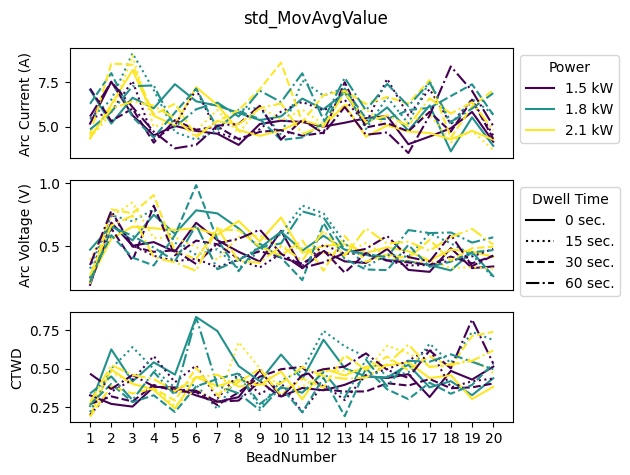

In [45]:
import numpy as np
import matplotlib.lines as mlines

powers = cv['Power Setpoint (kW)'].unique()
dwell_times = cv['Dwell Time (s)'].unique()
graphby = 'std_MovAvgValue'
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(powers)))
lss = ['solid', 'dotted', 'dashed', 'dashdot']
color_lines = []
ls_lines = []
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
for ddx, dT in enumerate(dwell_times):    
    for idx, power in enumerate(powers):
        aC = arcCurrent.loc[(power, dT, slice(None)), :].reset_index()
        aV = arcVoltage.loc[(power, dT, slice(None)), :].reset_index()
        CTWD = contactTipWD.loc[(power, dT, slice(None)), :].reset_index()
        ax1.plot(aC['BeadNumber'], aC[graphby], color=colors[idx], linestyle=lss[ddx])
        ax2.plot(aV['BeadNumber'], aV[graphby], color=colors[idx], linestyle=lss[ddx])
        ax3.plot(CTWD['BeadNumber'], CTWD[graphby], color=colors[idx], linestyle=lss[ddx])

        if ddx == 0:
            color_lines.append(mlines.Line2D([], [], color=colors[idx], label=f'{power} kW'))
        if idx == 0:
            ls_lines.append(mlines.Line2D([], [], color='black', linestyle=lss[ddx], label=f'{dT} sec.'))

# Add the legends to one of the axes (or all of them if desired)
ax1.legend(handles=color_lines, bbox_to_anchor=(1, 1), title='Power')
ax2.legend(handles=ls_lines, bbox_to_anchor=(1, 1), title='Dwell Time')

fig.suptitle(graphby)
ax1.set_xticks([]), ax2.set_xticks([])
plt.xlabel('BeadNumber')
plt.xticks(np.arange(1,21))
ax1.set_ylabel('Arc Current (A)'), ax2.set_ylabel('Arc Voltage (V)')
ax3.set_ylabel('CTWD')
plt.tight_layout()
plt.savefig(f'{graphby}.png', dpi=300)
